In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.spatial.distance import pdist, squareform
%matplotlib inline

import nengo
from nengo.params import Parameter, NumberParam, NdarrayParam
from nengo.neurons import settled_firingrate

def adjacency(num, ri, ro, sqR):
    nx = sqR*np.random.rand(num,2)
    D = squareform(pdist(nx))
    S = np.zeros((num, num))

    for index, x in np.ndenumerate(D):
        if (x < ri):
            S[index] = 30*x
        elif (x > ro):
            S[index] = -10*math.exp(-x / 10)        
    S = S - np.diag(np.diag(S)) 
    return S

class CustomLIF(nengo.neurons.NeuronType):
    """Spiking version of the leaky integrate-and-fire (LIF) neuron model.

    Parameters
    ----------
    tau_rc : float
        Membrane RC time constant, in seconds. Affects how quickly the membrane
        voltage decays to zero in the absence of input (larger = slower decay).
    tau_ref : float
        Absolute refractory period, in seconds. This is how long the
        membrane voltage is held at zero after a spike.
    min_voltage : float
        Minimum value for the membrane voltage. If ``-np.inf``, the voltage
        is never clipped.
    amplitude : float
        Scaling factor on the neuron output. Corresponds to the relative
        amplitude of the output spikes of the neuron.
    """

    probeable = ("spikes", "voltage", "refractory_time")

    min_voltage = NumberParam("min_voltage", high=0)
    tau_rc = NumberParam("tau_rc", low=0, low_open=True)
    tau_ref = NumberParam("tau_ref", low=0)
    amplitude = NumberParam("amplitude", low=0, low_open=True)
    num = NumberParam("num")
    S = NdarrayParam("S")  # adjacency matrix

    def __init__(self, S, num, tau_rc=0.02, tau_ref=0.002, min_voltage=0, amplitude=1):
        super().__init__()
        self.tau_rc = tau_rc
        self.tau_ref = tau_ref
        self.amplitude = amplitude
        self.min_voltage = min_voltage
        self.num = num
        self.S = S

    def gain_bias(self, max_rates, intercepts):
        """Analytically determine gain, bias."""
        max_rates = np.array(max_rates, dtype=float, copy=False, ndmin=1)
        intercepts = np.array(intercepts, dtype=float, copy=False, ndmin=1)

        inv_tau_ref = 1.0 / self.tau_ref if self.tau_ref > 0 else np.inf
        if np.any(max_rates > inv_tau_ref):
            raise ValidationError(
                "Max rates must be below the inverse "
                "refractory period (%0.3f)" % inv_tau_ref,
                attr="max_rates",
                obj=self,
            )

        x = 1.0 / (1 - np.exp((self.tau_ref - (1.0 / max_rates)) / self.tau_rc))
        gain = (1 - x) / (intercepts - 1.0)
        bias = 1 - gain * intercepts
        return gain, bias


    def max_rates_intercepts(self, gain, bias):
        """Compute the inverse of gain_bias."""
        intercepts = (1 - bias) / gain
        max_rates = 1.0 / (
            self.tau_ref - self.tau_rc * np.log1p(1.0 / (gain * (intercepts - 1) - 1))
        )
        if not np.all(np.isfinite(max_rates)):
            warnings.warn(
                "Non-finite values detected in `max_rates`; this "
                "probably means that `gain` was too small."
            )
        return max_rates, intercepts


    def rates(self, x, gain, bias):
        """Always use LIFRate to determine rates."""
        J = self.current(x, gain, bias)
        out = np.zeros_like(J)
        # Use LIFRate's step_math explicitly to ensure rate approximation
        LIFRate.step_math(self, dt=1, J=J, output=out)
        return out


    def step_math(self, dt, J, spiked, voltage, refractory_time):        
        print('init voltage = {}'.format(voltage))
        # reduce all refractory times by dt
        refractory_time -= dt

        # compute effective dt for each neuron, based on remaining time.
        # note that refractory times that have completed midway into this
        # timestep will be given a partial timestep, and moreover these will
        # be subtracted to zero at the next timestep (or reset by a spike)
        delta_t = (dt - refractory_time).clip(0, dt)

        
        # step voltage
        U = np.matmul(spiked, S)
        print('U = {}'.format(U))
        eta = 3*np.random.rand(3,)
        print('eta = {}'.format(eta))
        dV = (-1/self.tau_rc) * voltage + U + eta
        print('dV = {}'.format(dV))
        voltage[:] += dV * dt * 1000
        print('final voltage = {}'.format(voltage))
        
        # determine which neurons spiked (set them to 1/dt, else 0)
        spiked_mask = voltage > 1
        spiked[:] = spiked_mask * (self.amplitude / dt)
        print('spiked = {}'.format(spiked))

        # set v(0) = 1 and solve for t to compute the spike time
        t_spike = dt + self.tau_rc * np.log1p(
            -(voltage[spiked_mask] - 1) / (J[spiked_mask] - 1)
        )

        # set spiked voltages to zero, refractory times to tau_ref, and
        # rectify negative voltages to a floor of min_voltage
        voltage[voltage < self.min_voltage] = self.min_voltage
        voltage[spiked_mask] = 0
        refractory_time[spiked_mask] = self.tau_ref + t_spike

In [2]:
from nengo.builder.operator import Operator

class SimCustomLIF(Operator):
    """Set a neuron model output for the given input current.

    Implements ``neurons.step_math(dt, J, output, *states)``.

    Parameters
    ----------
    neurons : NeuronType
        The `.NeuronType`, which defines a ``step_math`` function.
    J : Signal
        The input current.
    output : Signal
        The neuron output signal that will be set.
    states : list, optional
        A list of additional neuron state signals set by ``step_math``.
    tag : str, optional
        A label associated with the operator, for debugging purposes.

    Attributes
    ----------
    J : Signal
        The input current.
    neurons : NeuronType
        The `.NeuronType`, which defines a ``step_math`` function.
    output : Signal
        The neuron output signal that will be set.
    states : list
        A list of additional neuron state signals set by ``step_math``.
    tag : str or None
        A label associated with the operator, for debugging purposes.

    Notes
    -----
    1. sets ``[output] + states``
    2. incs ``[]``
    3. reads ``[J]``
    4. updates ``[]``
    """

    def __init__(self, neurons, J, output, states=None, tag=None):
        super().__init__(tag=tag)
        self.neurons = neurons

        self.sets = [output] + ([] if states is None else states)
        self.incs = []
        self.reads = [J]
        self.updates = []

    @property
    def J(self):
        return self.reads[0]

    @property
    def output(self):
        return self.sets[0]

    @property
    def states(self):
        return self.sets[1:]

    def _descstr(self):
        return "%s, %s, %s" % (self.neurons, self.J, self.output)

    def make_step(self, signals, dt, rng):
        J = signals[self.J]
        output = signals[self.output]
        states = [signals[state] for state in self.states]

        def step_simcustomlif():
            self.neurons.step_math(dt, J, output, *states)

        return step_simcustomlif

In [3]:
from nengo.builder import Builder
from nengo.builder.operator import Copy
from nengo.builder.signal import Signal
from nengo.rc import rc


@Builder.register(CustomLIF)
def build_customlif(model, neuron_type, neurons):
    """Builds a `.LIF` object into a model.

    In addition to adding a `.SimNeurons` operator, this build function sets up
    signals to track the voltage and refractory times for each neuron.

    Parameters
    ----------
    model : Model
        The model to build into.
    neuron_type : CustomLIF
        Neuron type to build.
    neuron : Neurons
        The neuron population object corresponding to the neuron type.

    Notes
    -----
    Does not modify ``model.params[]`` and can therefore be called
    more than once with the same `.LIF` instance.
    """

    model.sig[neurons]["voltage"] = Signal(
        shape=neurons.size_in, name="%s.voltage" % neurons
    )
    model.sig[neurons]["refractory_time"] = Signal(
        shape=neurons.size_in, name="%s.refractory_time" % neurons
    )
    model.add_op(
        SimCustomLIF(
            neurons=neuron_type,
            J=model.sig[neurons]["in"],
            output=model.sig[neurons]["out"],
            states=[
                model.sig[neurons]["voltage"],
                model.sig[neurons]["refractory_time"],
            ],
        )
    )



S = [[ 0.         -1.14068925 -1.41880323]
 [-1.14068925  0.         -0.99762099]
 [-1.41880323 -0.99762099  0.        ]]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

init voltage = [0. 0. 0.]
U = [0. 0. 0.]
eta = [2.1023374  2.99255847 1.03432411]
dV = [2.1023374  2.99255847 1.03432411]
final voltage = [2.1023374  2.99255847 1.03432411]
spiked = [1000. 1000. 1000.]
init voltage = [0. 0. 0.]
U = [-2559.49248311 -2138.31024088 -2416.42421903]
eta = [1.34304651 2.6900454  1.20822596]
dV = [-2558.14943661 -2135.62019549 -2415.21599307]
final voltage = [-2558.14943661 -2135.62019549 -2415.21599307]
spiked = [0. 0. 0.]
init voltage = [0. 0. 0.]
U = [0. 0. 0.]
eta = [2.43942196 2.59244054 2.38556132]
dV = [2.43942196 2.59244054 2.38556132]
final voltage = [2.43942196 2.59244054 2.38556132]
spiked = [1000. 1000. 1000.]
init voltage = [0. 0. 0.]
U = [-2559.49248311 -2138.31024088 -2416.42421903]
eta = [0.34305322 2.57561652 2.29809301]
dV = [-2559.1494299  -2135.73462436 -2414.12612602]
final voltage = [-2559.1494299  -2135.73462436 -2414.12612602]
spiked = [0. 0. 0.]
init voltage = [0. 0. 0.]
U = [0. 0. 0.]
eta = [1.26128464 2.10187347 2.07412388]
dV = [1.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

Text(0, 0.5, 'Neuron number')

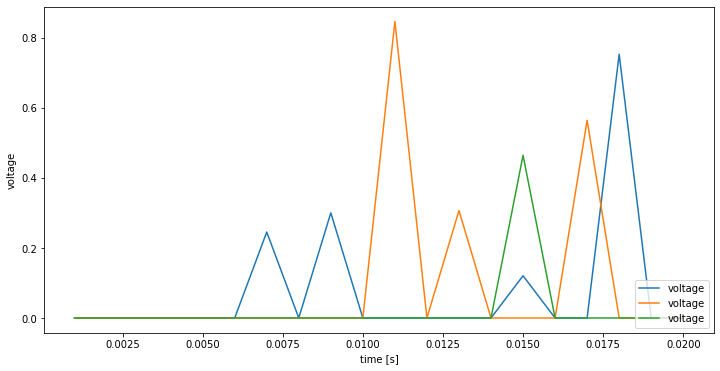

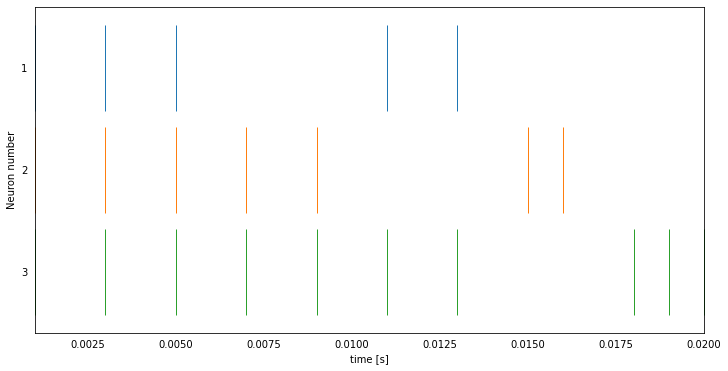

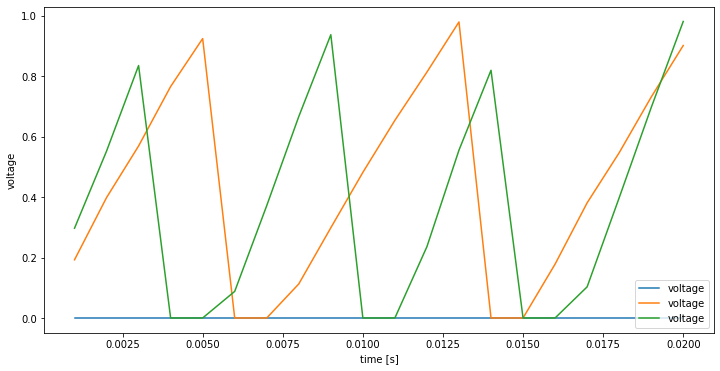

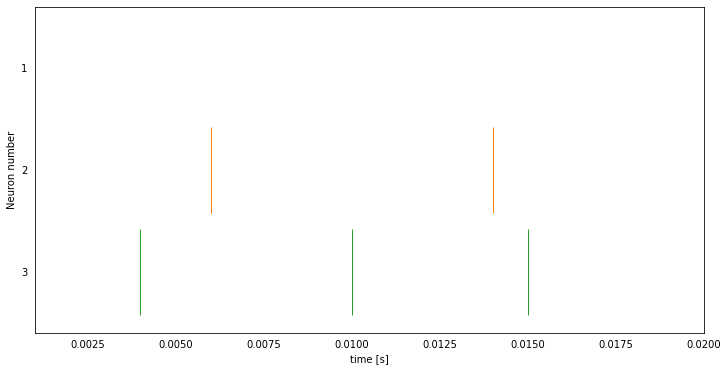

In [4]:
from nengo.utils.matplotlib import rasterplot

S = adjacency(3, 3, 6, 28)
print('S = {}'.format(S))

model = nengo.Network(label='2D Representation', seed=10)
process = nengo.processes.WhiteNoise(
    dist=nengo.dists.Gaussian(0, .01), seed=1)
with model:
    a = nengo.Ensemble(3, dimensions=2, noise=process, neuron_type=CustomLIF(S, 3))
    b = nengo.Ensemble(3, dimensions=2, noise=process, neuron_type=nengo.LIF())
    spikes_probe = nengo.Probe(a.neurons, 'spikes')
    voltage_probe = nengo.Probe(a.neurons, 'voltage')
    b_spikes = nengo.Probe(b.neurons, 'spikes')
    b_voltage = nengo.Probe(b.neurons, 'voltage')
with nengo.Simulator(model) as sim:
    sim.run(.02)
    
# Custom LIF neurons
plt.figure(figsize=(12, 6))
plt.plot(sim.trange(), sim.data[voltage_probe], label="voltage")
plt.xlabel('time [s]')
plt.ylabel('voltage')
plt.legend(loc=4);

plt.figure(figsize=(12, 6))
rasterplot(sim.trange(), sim.data[spikes_probe])
plt.xlabel('time [s]')
plt.ylabel('Neuron number')

# Compare to Nengo's LIF neurons
plt.figure(figsize=(12, 6))
plt.plot(sim.trange(), sim.data[b_voltage], label="voltage")
plt.xlabel('time [s]')
plt.ylabel('voltage')
plt.legend(loc=4);

plt.figure(figsize=(12, 6))
rasterplot(sim.trange(), sim.data[b_spikes])
plt.xlabel('time [s]')
plt.ylabel('Neuron number')

